In [34]:
import os, math, statsmodels
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns

from src.data_exploration import *

Notes
* Could look at seen lemmas in train + dev but not guaranteed to be distinct for SIGMORPHON so will need to re-do those numbers

# Loading, Parsing, and Adding Columns

We add the following columns to the data:
* test_acc_drop
* train_lemma_diff_raw
* train_lemma_diff_log
* train_lemma_diff_scaled
* train_size_diff_raw
* train_size_diff_scaled

In [87]:
replication = pd.read_csv("replication/replication.tsv", sep='\t').dropna()
replication['SIGMORPHON_train_size'] = replication['SIGMORPHON_train_size'].astype(float)


replication["test_acc_drop"] = replication["Goldman_test_acc"] - replication["SIGMORPHON_test_acc"]
replication["train_lemma_diff_raw"] = replication["Goldman_train_lemmas"] - replication["SIGMORPHON_train_lemmas"] 
replication["train_lemma_diff_log"] = np.log(-1*replication["train_lemma_diff_raw"])
replication["train_lemma_diff_scaled"] = 100* replication["train_lemma_diff_raw"] / replication["SIGMORPHON_train_lemmas"]
replication["train_size_diff_raw"] = replication["Goldman_train_size"] - replication["SIGMORPHON_train_size"] 
replication["train_size_diff_scaled"] = 100* replication["train_size_diff_raw"] / replication["SIGMORPHON_train_size"]

replication

,Family,Language,SIGMORPHON_dev_acc,SIGMORPHON_test_acc,Goldman_dev_acc,Goldman_test_acc,SIGMORPHON_train_size,Goldman_train_size,SIGMORPHON_dev_size,Goldman_dev_size,...,SIGMORPHON_test_lemmas,Goldman_train_lemmas,Goldman_dev_lemmas,Goldman_test_lemmas,test_acc_drop,train_lemma_diff_raw,train_lemma_diff_log,train_lemma_diff_scaled,train_size_diff_raw,train_size_diff_scaled
0,niger_congo,aka,100.0000,100.0000,39.7500,30.0385,2793.0,2747.0,380.0,410.0,...,95.0,67.0,10.0,19.0,-69.9615,-29.0,3.367296,-30.208333,-46.0,-1.646975
1,niger_congo,gaa,100.0000,99.4083,71.1111,53.2164,607.0,594.0,79.0,90.0,...,80.0,66.0,10.0,19.0,-46.1919,-29.0,3.367296,-30.526316,-13.0,-2.141680
2,niger_congo,kon,100.0000,98.0769,85.0000,88.1250,568.0,560.0,76.0,80.0,...,113.0,140.0,20.0,40.0,-9.9519,-59.0,4.077537,-29.648241,-8.0,-1.408451
3,niger_congo,lin,100.0000,100.0000,83.3333,56.2500,159.0,156.0,23.0,24.0,...,34.0,39.0,6.0,12.0,-43.7500,-18.0,2.890372,-31.578947,-3.0,-1.886792
4,niger_congo,lug,93.6605,90.5834,51.2552,18.5610,3420.0,3300.0,489.0,478.0,...,89.0,62.0,9.0,18.0,-72.0224,-27.0,3.295837,-30.337079,-120.0,-3.508772
5,niger_congo,nya,100.0000,100.0000,90.6178,75.8581,3031.0,3002.0,429.0,437.0,...,226.0,158.0,23.0,46.0,-24.1419,-69.0,4.234107,-30.396476,-29.0,-0.956780
6,niger_congo,sna,100.0000,100.0000,71.1111,26.2745,1897.0,1800.0,246.0,270.0,...,82.0,60.0,9.0,17.0,-73.7255,-26.0,3.258097,-30.232558,-97.0,-5.113337
7,niger_congo,sot,100.0000,97.9798,0.0000,0.0000,345.0,342.0,50.0,57.0,...,25.0,18.0,3.0,5.0,-97.9798,-8.0,2.079442,-30.769231,-3.0,-0.869565
8,niger_congo,swa,100.0000,100.0000,58.9796,42.9592,3374.0,3283.0,469.0,490.0,...,96.0,67.0,10.0,20.0,-57.0408,-30.0,3.401197,-30.927835,-91.0,-2.697095
9,niger_congo,zul,85.7143,92.3077,36.9565,32.2222,322.0,300.0,42.0,46.0,...,32.0,60.0,9.0,18.0,-60.0855,-27.0,3.295837,-31.034483,-22.0,-6.832298


In [145]:
def run_stats(df, col1, col2):
    """Here's a helper function to run some stats for us"""
    x = df[col1].to_numpy()
    y = df[col2].to_numpy()
    pearson = stats.pearsonr(x, y)
    spearman = stats.spearmanr(x, y)
    kendall_tau = stats.kendalltau(x, y)
    for name, stat in [("Pearson's R", pearson), ("Spearman", spearman), ("Kendall's Tau", kendall_tau)]:
        print(f"{name}:\t{stat.statistic :.3f},\t p = {stat.pvalue}")
        
def run_plotting(df, col1, col2, xlabel=None, ylabel=None, title=None):
    """Here's a helper function to handle SNS for us"""
    
    # Scatter plot all the languages together 
    sns.scatterplot(
        data=replication, 
        x=col1, 
        y=col2, 
        hue="Family",
        palette=["teal", "indigo"],
        alpha=0.6,
        s=80
    )
    plt.xlabel(col1 if xlabel is None else xlabel)
    plt.ylabel(col2 if ylabel is None else ylabel)
    plt.title(f"{col1} vs. {col2}" if title is None else title)
    plt.show()
    
    
    # Plot the languages separately 
    facet = sns.lmplot(
        data=replication, 
        x=col1, 
        y=col2, 
        hue="Family",
        col="Family",
        palette=["teal", "indigo"],
        facet_kws = {"sharex": False},
        ci=0,
    )

    if xlabel is not None:
        facet.axes[0,0].set_xlabel('Goldman et al. train size')
        facet.axes[0,1].set_xlabel('Goldman et al. train size')
    if ylabel is not None:
        facet.axes[0,0].set_ylabel('Test accuracy drop')
    if title is not None:
        facet.axes[0,1].set_title(f'Uralic {title}')
        facet.axes[0,0].set_title(f'Niger-Congo {title}')

    plt.show()
    
    
    # Run stats
    print("-------------------\nAll Families:\n-------------------")
    run_stats(replication, col1, col2)
    print("\n-------------------\nNiger-Congo:\n-------------------")
    run_stats(replication.query("Family == 'niger_congo'"), col1, col2)
    print("\n-------------------\nUralic:\n-------------------")
    run_stats(replication.query("Family == 'uralic'"), col1, col2)

# Initial Replication: Training Size vs. Test Accuracy Drop

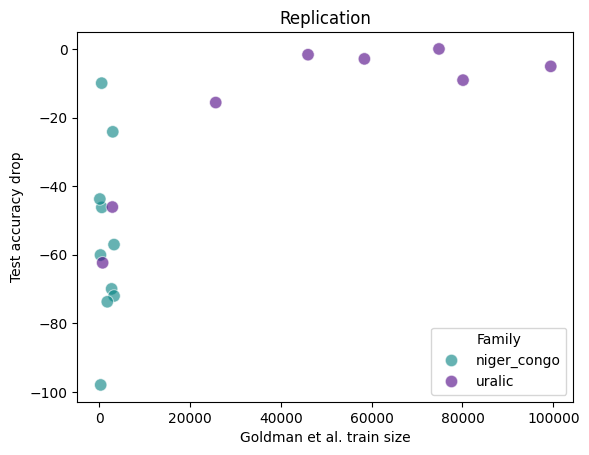

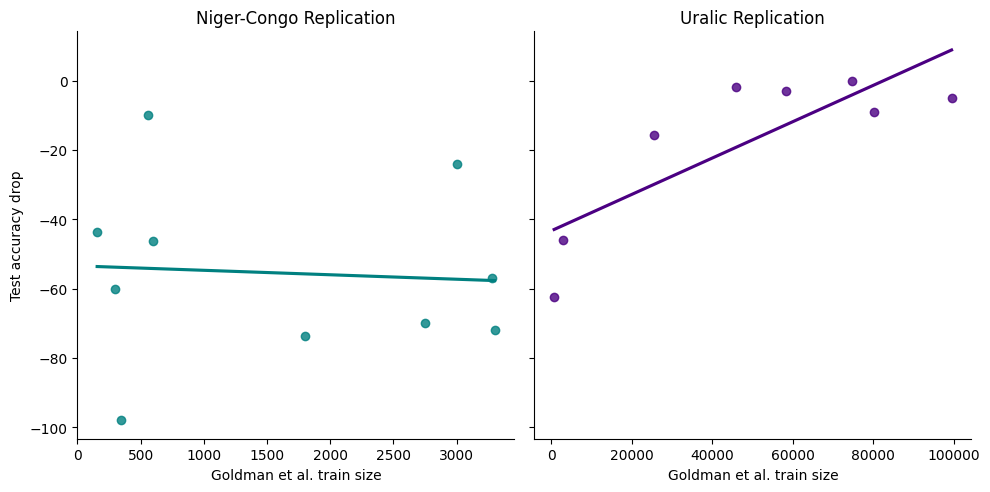

-------------------
All Families:
-------------------
Pearson's R:	0.726,	 p = 0.0006521727860318387
Spearman:	0.624,	 p = 0.0056112726298920695
Kendall's Tau:	0.425,	 p = 0.013730471770781806

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.068,	 p = 0.8519813936265076
Spearman:	-0.127,	 p = 0.7260570147627894
Kendall's Tau:	-0.111,	 p = 0.7274895282186948

-------------------
Uralic:
-------------------
Pearson's R:	0.817,	 p = 0.013298449424879934
Spearman:	0.619,	 p = 0.1017330374542646
Kendall's Tau:	0.500,	 p = 0.10868055555555556


In [146]:
run_plotting(replication, 
             "Goldman_train_size", 
             "test_acc_drop",
             xlabel="Goldman et al. train size",
             ylabel="Test accuracy drop",
             title="Replication"
            )

## The Role of Training Lemmas

### Training Lemma Count 

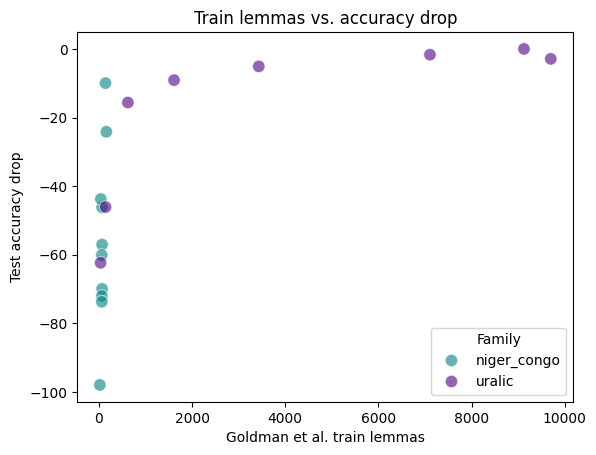

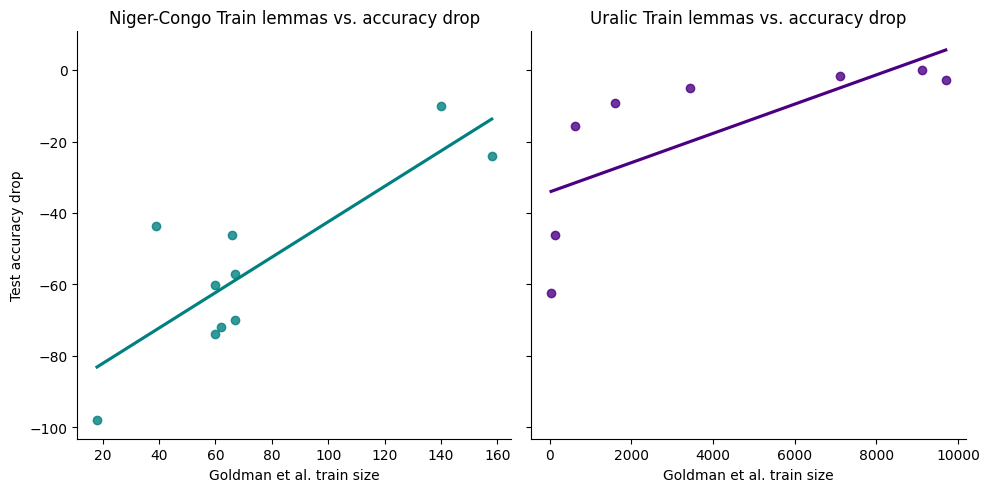

-------------------
All Families:
-------------------
Pearson's R:	0.662,	 p = 0.0027785588561834136
Spearman:	0.876,	 p = 1.8874666347979783e-06
Kendall's Tau:	0.743,	 p = 1.8164556327265218e-05

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.826,	 p = 0.003207316919283858
Spearman:	0.622,	 p = 0.05485939233686208
Kendall's Tau:	0.477,	 p = 0.058290580139488755

-------------------
Uralic:
-------------------
Pearson's R:	0.714,	 p = 0.04659572686166586
Spearman:	0.929,	 p = 0.0008629681828999769
Kendall's Tau:	0.857,	 p = 0.001736111111111111


In [148]:
run_plotting(replication, 
             "Goldman_train_lemmas", 
             "test_acc_drop",
             xlabel="Goldman et al. train lemmas",
             ylabel="Test accuracy drop",
             title="Train lemmas vs. accuracy drop"
            )

### Raw Difference in Number of Training Lemmas

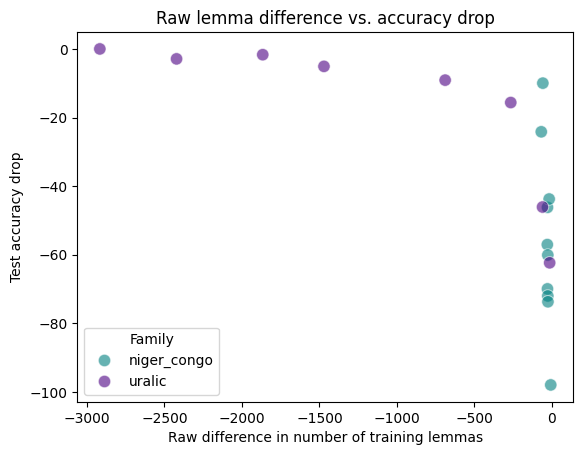

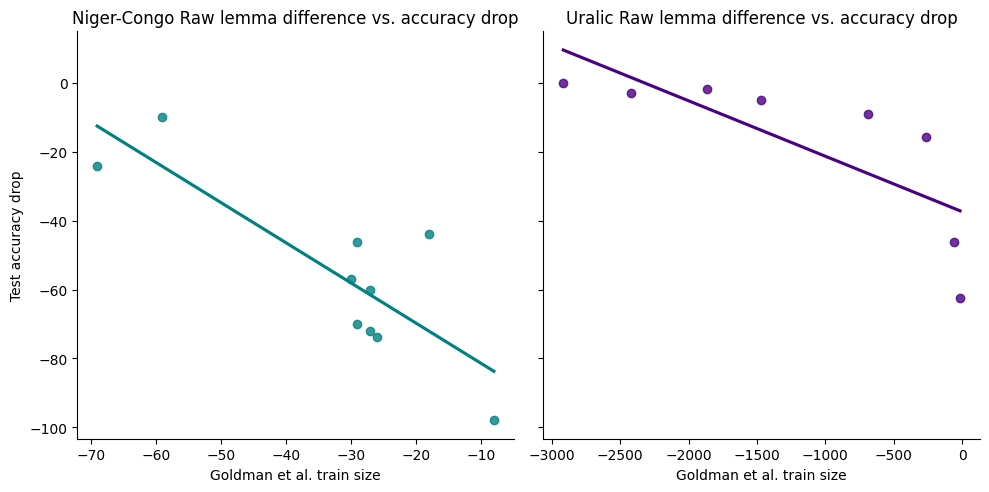

-------------------
All Families:
-------------------
Pearson's R:	-0.698,	 p = 0.0012632655844298055
Spearman:	-0.895,	 p = 5.464961715359718e-07
Kendall's Tau:	-0.783,	 p = 6.363804277262756e-06

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.828,	 p = 0.0030830571342569586
Spearman:	-0.683,	 p = 0.0295125778506635
Kendall's Tau:	-0.568,	 p = 0.024185218322711265

-------------------
Uralic:
-------------------
Pearson's R:	-0.772,	 p = 0.02493660196546467
Spearman:	-0.976,	 p = 3.3143960262001043e-05
Kendall's Tau:	-0.929,	 p = 0.0003968253968253968


In [152]:
# Raw difference in training lemmas between SIGMORPHON and Goldman
run_plotting(replication, 
             "train_lemma_diff_raw", 
             "test_acc_drop",
             xlabel="Raw difference in number of training lemmas",
             ylabel="Test accuracy drop",
             title="Raw lemma difference vs. accuracy drop"
            )

### Scaled Difference in Number of Training Lemmas

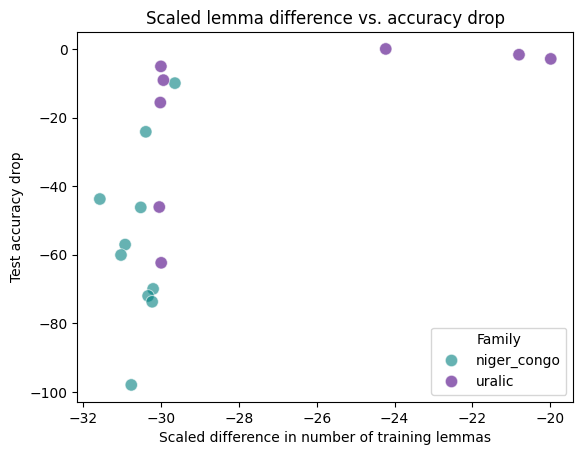

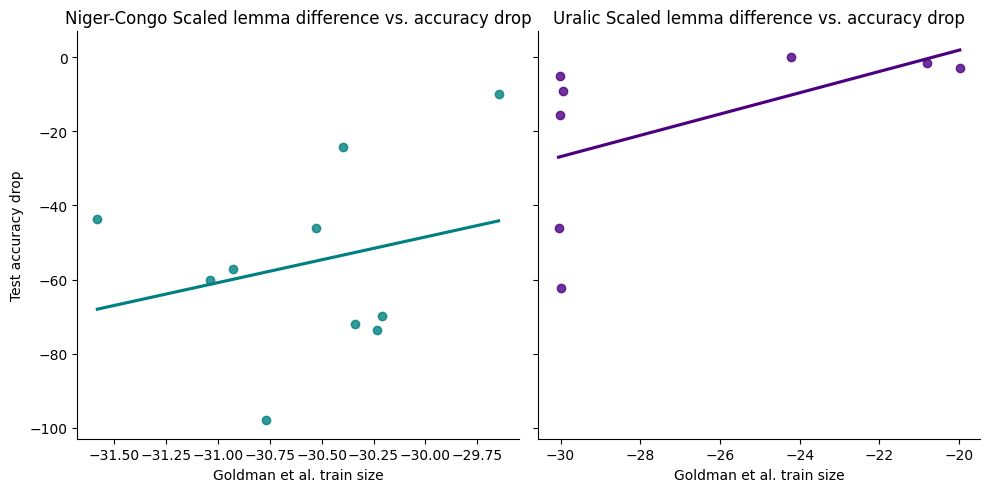

-------------------
All Families:
-------------------
Pearson's R:	0.582,	 p = 0.011205551831740733
Spearman:	0.670,	 p = 0.0023600851881755407
Kendall's Tau:	0.503,	 p = 0.002985699542918576

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.258,	 p = 0.47196855757315487
Spearman:	-0.006,	 p = 0.9867429111949892
Kendall's Tau:	0.022,	 p = 1.0

-------------------
Uralic:
-------------------
Pearson's R:	0.550,	 p = 0.1574404246392787
Spearman:	0.714,	 p = 0.04652823228416724
Kendall's Tau:	0.500,	 p = 0.10868055555555556


In [153]:
# Percent difference in training lemmas between SIGMORPHON and Goldman et al.
run_plotting(replication, 
             "train_lemma_diff_scaled", 
             "test_acc_drop",
             xlabel="Scaled difference in number of training lemmas",
             ylabel="Test accuracy drop",
             title="Scaled lemma difference vs. accuracy drop"
            )

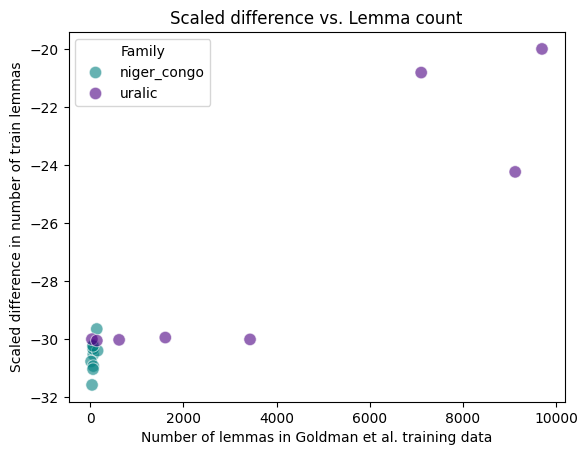

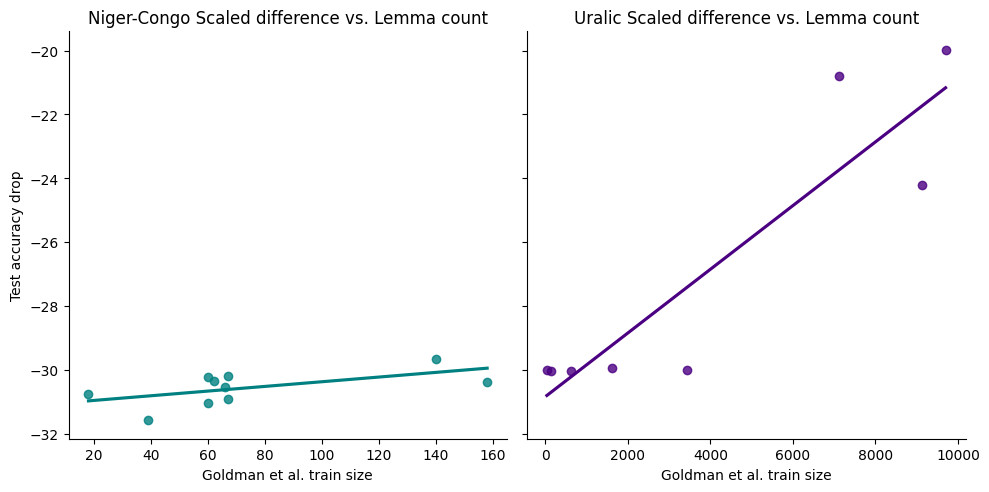

-------------------
All Families:
-------------------
Pearson's R:	0.931,	 p = 2.0781624984206253e-08
Spearman:	0.726,	 p = 0.0006429317525484849
Kendall's Tau:	0.586,	 p = 0.0007355796414357407

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.584,	 p = 0.07605818711785683
Spearman:	0.530,	 p = 0.11467188344055661
Kendall's Tau:	0.386,	 p = 0.12531568180831723

-------------------
Uralic:
-------------------
Pearson's R:	0.908,	 p = 0.0018107944787975584
Spearman:	0.786,	 p = 0.020815127253525276
Kendall's Tau:	0.643,	 p = 0.03115079365079365


In [154]:
# Is there a relationship between scaled difference and train size?
run_plotting(replication, 
             "Goldman_train_lemmas", 
             "train_lemma_diff_scaled",
             xlabel="Number of lemmas in Goldman et al. training data",
             ylabel="Scaled difference in number of train lemmas",
             title="Scaled difference vs. Lemma count"
            )